In [1]:
import pathlib
import pandas as pd
import pybedtools
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from cemba_data.plot import *
from concurrent.futures import ProcessPoolExecutor, as_completed

pathlib.Path('bed_tmp').mkdir(exist_ok=True)
pybedtools.set_tempdir('bed_tmp')

In [2]:
from matplotlib import rc

labelsize = 6
fontsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

In [3]:
chrom_size_path = '/home/hanliu/ref/mouse/genome/mm10.main.chrom.sizes'
cluster_level = 'SubType'
slop = 250

## DMR


In [4]:
dmr_bed_dir = pathlib.Path(f'/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/')

hypo_dmr_dict = {}
for path in dmr_bed_dir.glob('Hypo*/*.bed'):
    cluster = path.name.split('.')[0]
    hypo_dmr_dict[cluster] = pybedtools.BedTool(str(path)).slop(b=slop, g=chrom_size_path)

hyper_dmr_dict = {}
for path in dmr_bed_dir.glob('Hyper*/*.bed'):
    cluster = path.name.split('.')[0]
    hyper_dmr_dict[cluster] = pybedtools.BedTool(str(path)).slop(b=slop, g=chrom_size_path)

hypo_dmr_count = {k: v.to_dataframe().shape[0] for k, v in hypo_dmr_dict.items()}
hypo_dmr_count = pd.Series(hypo_dmr_count)

hyper_dmr_count = {k: v.to_dataframe().shape[0] for k, v in hyper_dmr_dict.items()}
hyper_dmr_count = pd.Series(hyper_dmr_count)

## Peak

In [5]:
atac_peak_version = 'v2'

In [6]:
peak_bed_dir = pathlib.Path(f'/home/hanliu/project/mouse_rostral_brain/study/mCClusterATACPeak/{atac_peak_version}/{cluster_level}')

peak_dict = {}
for path in peak_bed_dir.glob('*bed'):
    cluster = path.name.split('.')[0]
    peak_dict[cluster] = pybedtools.BedTool(str(path))
    
peak_count = {k: v.to_dataframe().shape[0] for k, v in peak_dict.items()}
peak_count = pd.Series(peak_count)

## DMR accessibility profile

In [7]:
open_dmr_dir = pathlib.Path(cluster_level + '/OpenDMR').absolute()
open_dmr_dir.mkdir(exist_ok=True, parents=True)

close_dmr_dir = pathlib.Path(cluster_level + '/CloseDMR').absolute()
close_dmr_dir.mkdir(exist_ok=True, parents=True)

def dmr_open_profile(cluster, dmr_type, dmr_bed, atac_bed):
    dmr_open = dmr_bed.intersect(b=atac_bed, wa=True, u=True)
    dmr_open.saveas(open_dmr_dir / f'{cluster}.{dmr_type}.Open.bed')
    dmr_close = dmr_bed.intersect(b=atac_bed, v=True)
    dmr_close.saveas(close_dmr_dir / f'{cluster}.{dmr_type}.Close.bed')
    return dmr_open.to_dataframe().shape[0], dmr_close.to_dataframe().shape[0]

dmr_open_record = {}

with ProcessPoolExecutor(40) as executor:
    futures = {}
    for cluster in hyper_dmr_dict.keys():
        hyper_dmr_bed = hyper_dmr_dict[cluster]
        hypo_dmr_bed = hypo_dmr_dict[cluster]
        atac_bed = peak_dict[cluster]
        
        future = executor.submit(dmr_open_profile, cluster, 'HyperDMR', hyper_dmr_bed, atac_bed)
        futures[future] = ('hyper', cluster)
        future = executor.submit(dmr_open_profile, cluster, 'HypoDMR', hypo_dmr_bed, atac_bed)
        futures[future] = ('hypo', cluster)
        
    for future in as_completed(futures):
        dmr_type, cluster = futures[future]
        dmr_open_record[(dmr_type, cluster)] = future.result()

dmr_df = pd.DataFrame(dmr_open_record)
dmr_df = dmr_df.T.reset_index()
dmr_df.columns = ['DMR Type', 'Cluster', 'Open Count', 'Close Count']
dmr_df['Total Count'] = dmr_df[['Open Count', 'Close Count']].sum(axis=1)

In [8]:
cluster_order = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/order/SubType.order.txt',
    index_col=0,
    header=None).index

fontsize = 6

palette = {
    'CloseHyperDMR': (1.0, 0.7333333333333333, 0.47058823529411764),
    'OpenHyperDMR': (1.0, 0.4980392156862745, 0.054901960784313725),
    'CloseHypoDMR':
    (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
    'OpenHypoDMR':
    (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
    'OpenNonDMR': (0.8, 0.8, 0.8)
}

In [9]:
cluster_order = [c.replace(' ', '_') for c in cluster_order]

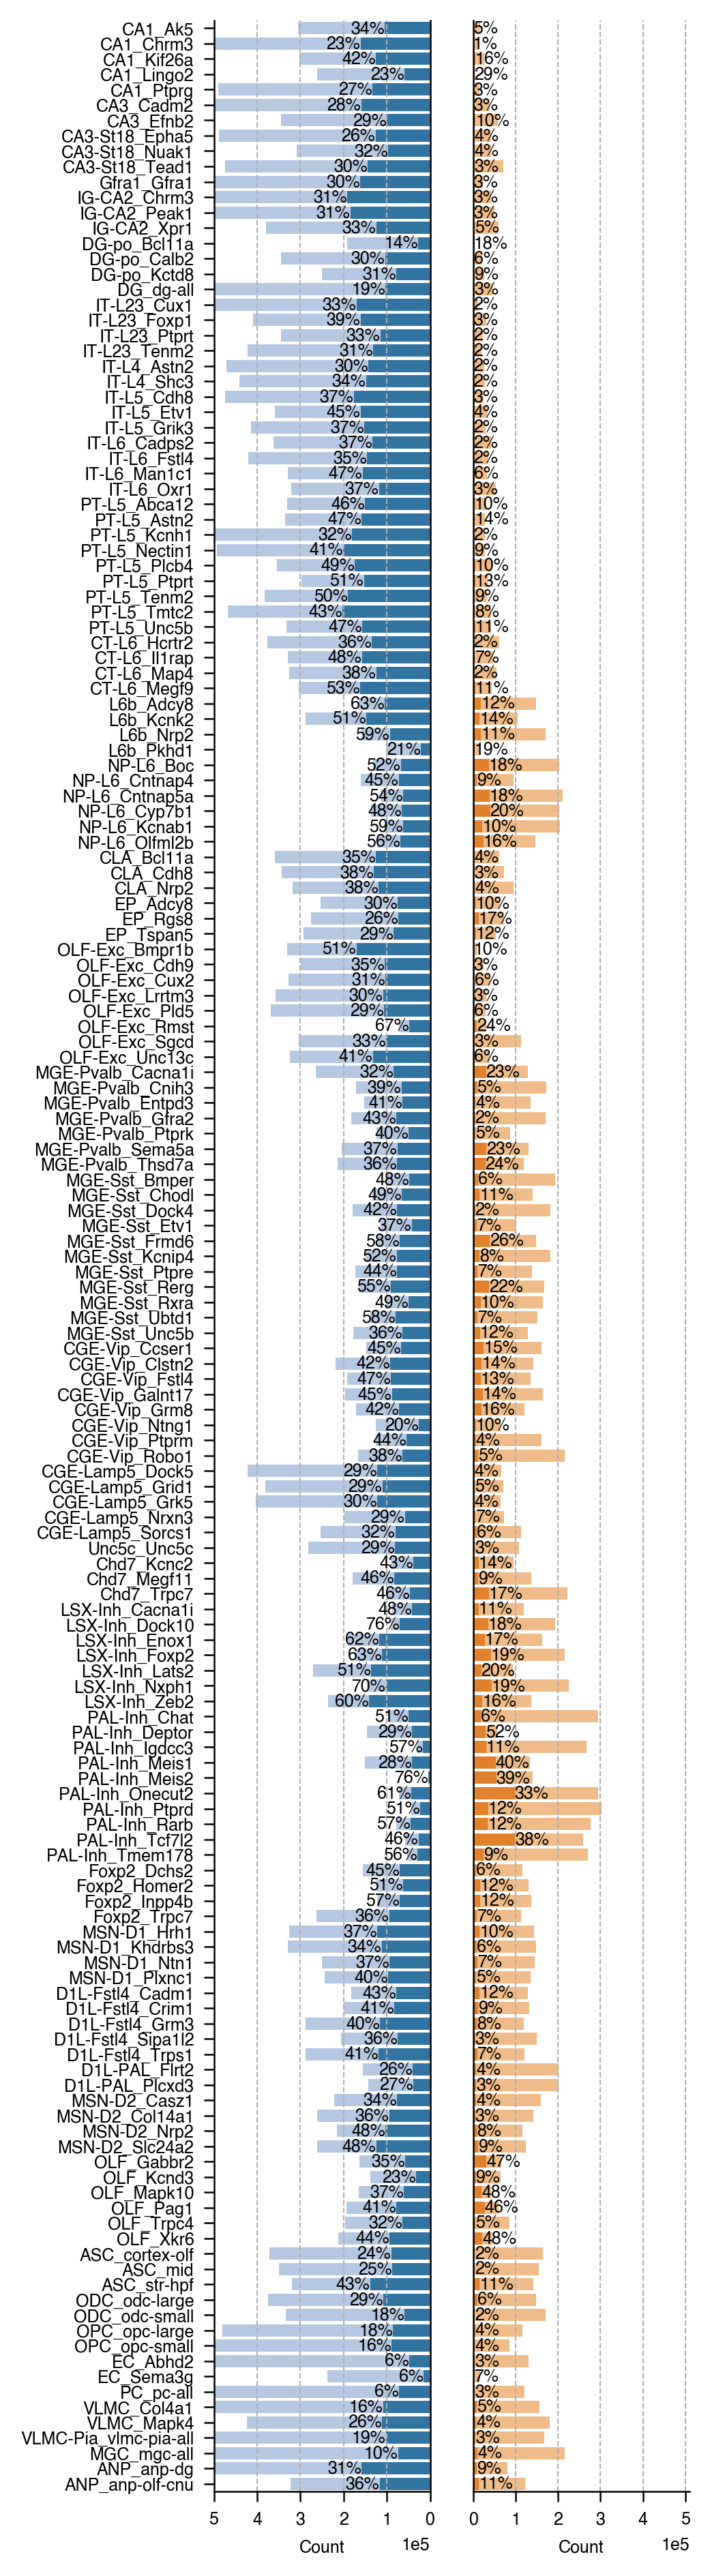

In [10]:
fig, (ax_hypo, ax_hyper) = plt.subplots(figsize=(3, 16), dpi=300, ncols=2)

# hyper
ax = ax_hyper
bar_data = dmr_df[dmr_df['DMR Type'] == 'hyper'].set_index('Cluster')[[
    'Open Count', 'Total Count'
]].stack().reset_index()
bar_data.columns = ['Cluster', 'Type', 'Count']
sns.barplot(ax=ax, data=bar_data, x='Count', y='Cluster', order=cluster_order, 
            hue='Type', dodge=False, hue_order=['Total Count', 'Open Count'],
            palette={'Total Count': palette['CloseHyperDMR'], 
                     'Open Count': palette['OpenHyperDMR']})

counts = bar_data.set_index(['Cluster', 'Type'])
for i, cluster in enumerate(cluster_order):
    x = counts.loc[(cluster, 'Open Count')][0]
    total = counts.loc[(cluster, 'Total Count')][0]
    percent = '{:.0f}%'.format(x * 100 / total)
    ax.text(x, i, percent, va='center', fontsize=fontsize)

ax.set(yticklabels=[], yticks=[], ylabel='', xlim=(0, 5.1e5))
ax.set_xticks([0, 1e5, 2e5, 3e5, 4e5, 5e5])
ax.legend_.set_visible(False)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.grid(axis='x', linewidth=0.5, linestyle='--')
sns.despine(ax=ax)

# hypo
ax = ax_hypo
bar_data = dmr_df[dmr_df['DMR Type'] == 'hypo'].set_index('Cluster')[[
    'Open Count', 'Total Count'
]].stack().reset_index()
bar_data.columns = ['Cluster', 'Type', 'Count']
sns.barplot(ax=ax, data=bar_data, x='Count', y='Cluster', order=cluster_order, 
            hue='Type', dodge=False, hue_order=['Total Count', 'Open Count'],
            palette={'Total Count': palette['CloseHypoDMR'], 
                     'Open Count': palette['OpenHypoDMR']})

counts = bar_data.set_index(['Cluster', 'Type'])
for i, cluster in enumerate(cluster_order):
    x = counts.loc[(cluster, 'Open Count')][0]
    total = counts.loc[(cluster, 'Total Count')][0]
    percent = '{:.0f}%'.format(x * 100 / total)
    ax.text(x, i, percent, va='center', ha='right', fontsize=fontsize)

ax.set(yticklabels=cluster_order, ylabel='', xlim=(5e5, 0))
ax.set_xticks([0, 1e5, 2e5, 3e5, 4e5, 5e5])
sns.despine(ax=ax, right=False)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.grid(axis='x', linewidth=0.5, linestyle='--')
ax.legend_.set_visible(False)

fig.savefig('SubType DMR accessibility profile.pdf', bbox_inches='tight')

In [11]:
bar_data.to_csv('SubType_DMR_Accessibility.bar_data.csv')

## ATAC methylation level

In [14]:
hyper_peak_dir = pathlib.Path(cluster_level + '/HyperPeak').absolute()
hyper_peak_dir.mkdir(exist_ok=True, parents=True)

hypo_peak_dir = pathlib.Path(cluster_level + '/HypoPeak').absolute()
hypo_peak_dir.mkdir(exist_ok=True, parents=True)

not_hypo_peak_dir = pathlib.Path(cluster_level + '/NotHypoPeak').absolute()
not_hypo_peak_dir.mkdir(exist_ok=True, parents=True)


def atac_mc_profile(cluster, atac_bed, hyper_bed, hypo_bed):
    hyper_peak = atac_bed.intersect(b=hyper_bed, wa=True, u=True)
    hyper_peak.saveas(hyper_peak_dir / f'{cluster}.bed')
    
    hypo_peak = atac_bed.intersect(b=hypo_bed, wa=True, u=True)
    hypo_peak.saveas(hypo_peak_dir / f'{cluster}.bed')
    
    not_hypo_peak = atac_bed.intersect(b=hypo_bed, v=True)
    not_hypo_peak.saveas(not_hypo_peak_dir / f'{cluster}.bed')
    return hyper_peak.count(), hypo_peak.count()

peak_record = {}

with ProcessPoolExecutor(40) as executor:
    futures = {}
    for cluster in hyper_dmr_dict.keys():
        hyper_dmr_bed = hyper_dmr_dict[cluster]
        hypo_dmr_bed = hypo_dmr_dict[cluster]
        atac_bed = peak_dict[cluster]
        
        future = executor.submit(atac_mc_profile, cluster, atac_bed, hyper_dmr_bed, hypo_dmr_bed)
        futures[future] = cluster
        
    for future in as_completed(futures):
        cluster = futures[future]
        peak_record[cluster] = future.result()

peak_df = pd.DataFrame(peak_record).T

peak_df.index.name = 'Cluster'
peak_df.columns = ['Hyper Count', 'Hypo Count']
peak_df['Total Count'] = peak_count
peak_df['Hyper+Hypo'] = peak_df['Hyper Count'] + peak_df['Hypo Count']
bar_data = peak_df[['Hyper Count', 'Hyper+Hypo', 'Total Count']].unstack().reset_index()
bar_data.columns = ['Type', 'Cluster', 'Count']

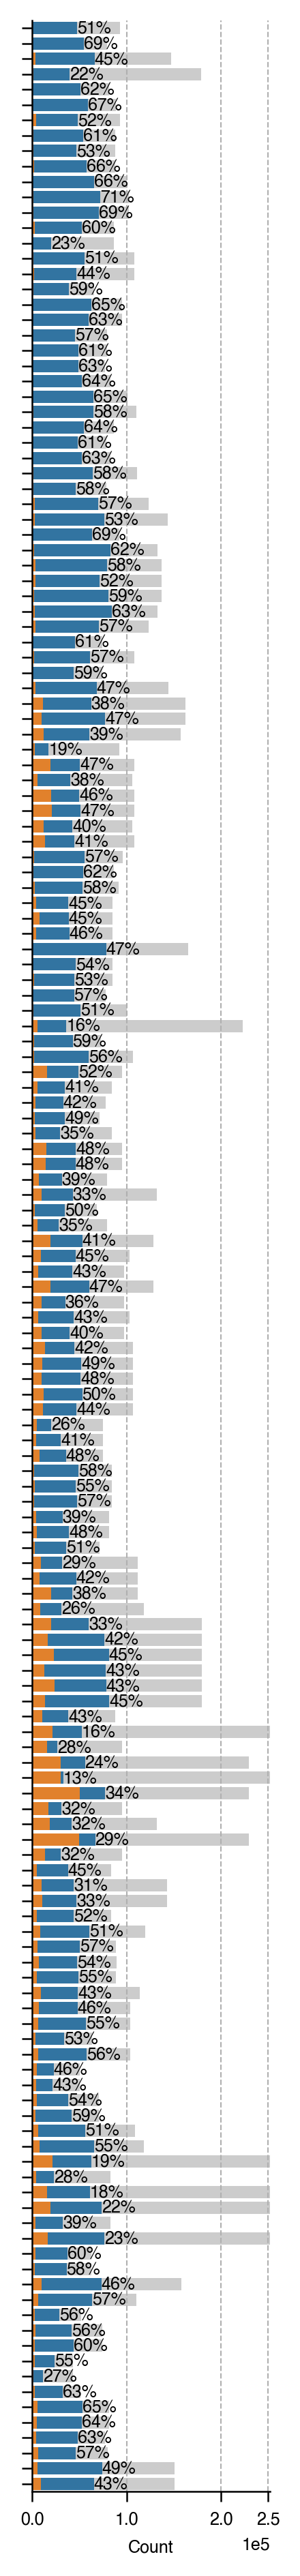

In [15]:
fontsize = 6

fig, ax = plt.subplots(figsize=(1.5, 16), dpi=300)

# hyper
sns.barplot(ax=ax, data=bar_data, x='Count', y='Cluster', order=cluster_order, 
            hue='Type', dodge=False, hue_order=['Total Count', 'Hyper+Hypo', 'Hyper Count'],
            palette={'Total Count': palette['OpenNonDMR'], 
                     'Hyper+Hypo': palette['OpenHypoDMR'],
                     'Hyper Count': palette['OpenHyperDMR']}
           )

counts = bar_data.set_index(['Cluster', 'Type'])
for i, cluster in enumerate(cluster_order):
    x = counts.loc[(cluster, 'Hyper+Hypo')][0]
    total = counts.loc[(cluster, 'Total Count')][0]
    percent = f'{x * 100 / total:.0f}%'
    ax.text(x, i, percent, va='center', fontsize=fontsize)

ax.set(yticklabels=[], ylabel='', xlim=(0, 2.52e5))
ax.set_xticks([0, 1e5, 2e5, 2.5e5])
ax.legend_.set_visible(False)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.grid(axis='x', linewidth=0.5, linestyle='--')
sns.despine(ax=ax)

fig.savefig('SubType peak mC profile.pdf', bbox_inches='tight')

In [16]:
bar_data.to_csv('SubType_ATAC_Peak_DMR_Profile.bar_data.csv')